# 目的
キックスタータープロジェクトが、成功するのか失敗するのか予想するモデル作成を目的とする。

データは、ks-projects-201801.csv

目的変数は、state

予想するのは、0:failed もしくは 1:successful の２値のみで、その他は無視する

## ライブラリ・データのインポート

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection 
import sklearn.svm
import sklearn.preprocessing

In [2]:
df = pd.read_csv("ks-projects-201801.csv", parse_dates=True)

## データの説明
Jupyter Notebook では、なぜか右寄せになってしまう

| 列名 | 説明 | 要不要 |
| :--- | :--- | :--- |
| ID            | 内部ID           | 不要 |
| name          | プロジェクト名   | 必要。例えば、現れる単語によって、成功率が変わるかもしれない |
| category      | サブカテゴリ     | 必要 |
| main_category | メインカテゴリ   | 必要 |
| currency      | 通貨名           | 必要 |
| deadline      | 終了日           | 必要 |
| goal          | 目標金額         | 通貨の単位がマチマチなので使えない |
| launched      | 開始日           | 必要 |
| pledged       | 実際に集まった額 | 不要 (目的変数) |
| state         | プロジェクトの現状 | 目的変数 |
| backers       | パトロンの人数   | 不要 (目的変数) |
| country       | 国名             | 必要 |
| usd pledged   | US＄で集まった額？ | 不要 (目的変数) |
| usd_pledged_real | US＄換算のpledged？ | 不要 (目的変数) |
| usd_goal_real | US＄換算のgoal？ | 必要 |

In [3]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [5]:
df.describe(include='all')

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,378657,378661,378661,378661,378661,3.786610e+05,378661,3.786610e+05,378661,378661.000000,378661,3.748640e+05,3.786610e+05,3.786610e+05
unique,NaN,375764,159,15,14,3164,NaN,378089,NaN,6,NaN,23,NaN,NaN,NaN
top,NaN,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,NaN,1970-01-01 01:00:00,NaN,failed,NaN,US,NaN,NaN,NaN
freq,NaN,41,22314,63585,295365,705,NaN,7,NaN,197719,NaN,292627,NaN,NaN,NaN
mean,1.074731e+09,NaN,NaN,NaN,NaN,NaN,4.908079e+04,NaN,9.682979e+03,NaN,105.617476,NaN,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,NaN,NaN,NaN,NaN,NaN,1.183391e+06,NaN,9.563601e+04,NaN,907.185035,NaN,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,NaN,NaN,NaN,NaN,NaN,1.000000e-02,NaN,0.000000e+00,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,NaN,NaN,NaN,NaN,NaN,2.000000e+03,NaN,3.000000e+01,NaN,2.000000,NaN,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,NaN,NaN,NaN,NaN,NaN,5.200000e+03,NaN,6.200000e+02,NaN,12.000000,NaN,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,NaN,NaN,NaN,NaN,NaN,1.600000e+04,NaN,4.076000e+03,NaN,56.000000,NaN,3.034090e+03,4.050000e+03,1.550000e+04


## 目標
本来は、全 378,661 件中 46,986 件はその他に分類されるはずなので、精度は最大でも 87.6% 程度となる

今回は、残り 331,675 件のデータを前提として考える

この時、全て failed と予想するモデルを考えると、Accuracy(正解率)は 59.6% となる

よって、この正解率を超えるモデルの作成を目標とする

In [6]:
# successful, failed, その他の件数
df.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

## state2
state2 列に 0:failed もしくは 1:successful を代入する

In [7]:
# failed or successful のみとする
df = df.copy()[(df.state == "failed") | (df.state == "successful")]

# state2 = 0:faled, 1:successful
df["state2"] = 0
df.loc[df.state == "successful", "state2"] = 1

## 各説明変数と成功率のグラフ
name2（nameの文字数）を見ると、文字数が多いほうが成功率が高い

name3（スペースの数。英文はスペース区切りなので、通常は「スペースの数＋１＝単語数」となるはず）は、5～15単語の成功率が高い。

launched.year, deadline.year は、年を追うごとに失敗率が上がっている

days（deadline と launched の差(日数)）は、期間が短い方が成功率が高い

usd_goal_real2（usd_goal_real の１万分の１）は、ある金額以上は成功率が低いことが分かる

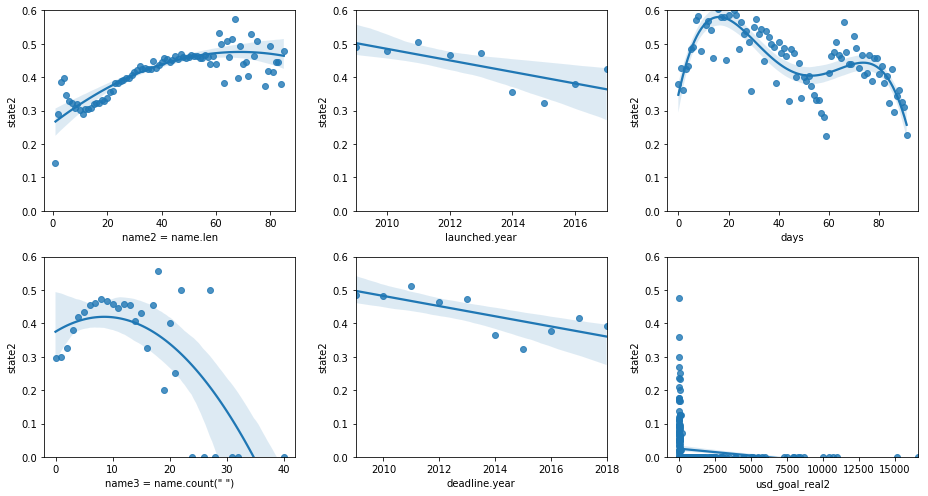

In [8]:
# datetime 型に変換する
launched = pd.to_datetime(df.launched)
deadline = pd.to_datetime(df.deadline)

# グラフ描画
def sns_regplot(df, ax, name, lx, ly, so=1):
    z = df.groupby(name).state2.mean()
    t = sns.regplot(z.index.array, z.values, order=so, ax=ax)
    t.set_xlabel(lx)
    t.set_ylabel(ly)
    ax.set_ylim(0, 0.6)

_, ax = plt.subplots(2, 3, figsize=(13,7))

df["name2"] = df.name.str.len()
sns_regplot(df, ax[0,0], "name2", "name2 = name.len", "state2", so=2)
df["name3"] = df.name.str.count(" ")
sns_regplot(df, ax[1,0], "name3", 'name3 = name.count(" ")', "state2", so=2)
df["launched.year"] = launched.dt.year
sns_regplot(df, ax[0,1], "launched.year", "launched.year", "state2")
df["deadline.year"] = deadline.dt.year
sns_regplot(df, ax[1,1], "deadline.year", "deadline.year", "state2")
df["days"] = (deadline - launched).dt.days
sns_regplot(df, ax[0,2], "days", "days", "state2", 4)
df["usd_goal_real2"] = df.usd_goal_real // 10000
sns_regplot(df, ax[1,2], "usd_goal_real2", "usd_goal_real2", "state2", 0)

plt.tight_layout()

## usd_goal_real2 と成功率のグラフ
X軸の範囲を狭くしたところ、金額と成功率は反比例していることが分かった

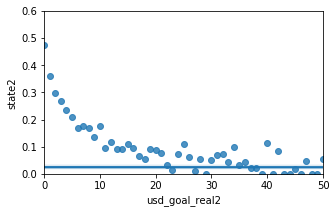

In [9]:
_, ax = plt.subplots(1, 1, figsize=(5,3))
ax.set_xlim(0, 50)
sns_regplot(df, ax, "usd_goal_real2", "usd_goal_real2", "state2", 0)

## 各説明変数と成功率のグラフ２
こちらは、Y軸のスケールを変更している。state2への貢献度は低そう。

launched.month, deadline.month は、春秋の成功率が高く、夏冬は低い

launched.day, deadline.day は、月初の成功率が高く、月末は低い

launched.dayofweek, deadline.dayofweek（0:月曜～6:日曜）は、週初めの成功率が高い

C:\Users\TDN09084\AppData\Roaming\Python\Python37\site-packages\seaborn\regression.py:250: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
C:\Users\TDN09084\AppData\Roaming\Python\Python37\site-packages\seaborn\regression.py:250: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
C:\Users\TDN09084\AppData\Roaming\Python\Python37\site-packages\seaborn\regression.py:250: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
C:\Users\TDN09084\AppData\Roaming\Python\Python37\site-packages\seaborn\regression.py:250: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


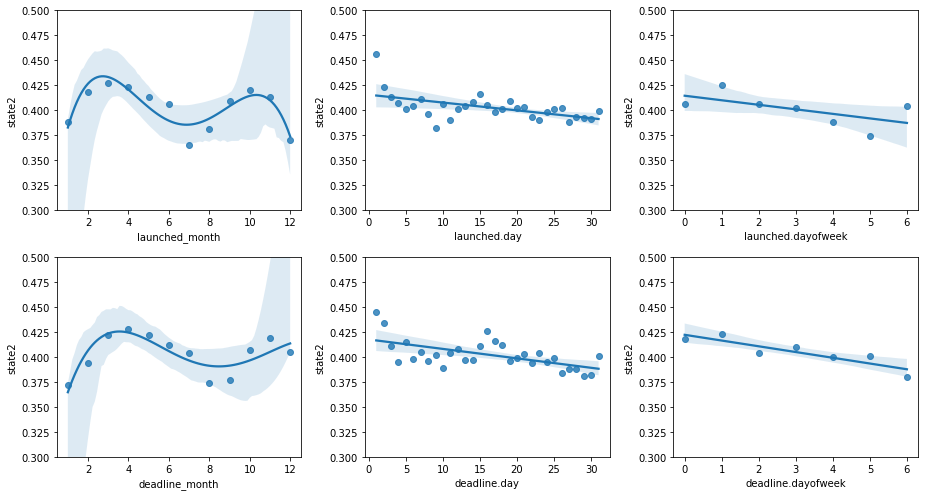

In [10]:
def sns_regplot(df, ax, name, lx, ly, so=1):
    z = df.groupby(name).state2.mean()
    t = sns.regplot(z.index.array, z.values, order=so, ax=ax)
    t.set_xlabel(lx)
    t.set_ylabel(ly)
    ax.set_ylim(0.3, 0.5)

_, ax = plt.subplots(2, 3, figsize=(13,7))
df["launched.month"] = launched.dt.month
sns_regplot(df, ax[0,0], "launched.month", "launched_month", "state2", 4)
df["deadline.month"] = deadline.dt.month
sns_regplot(df, ax[1,0], "deadline.month", "deadline_month", "state2", 4)
df["launched.day"] = launched.dt.day
sns_regplot(df, ax[0,1], "launched.day", "launched.day", "state2")
df["deadline.day"] = deadline.dt.day
sns_regplot(df, ax[1,1], "deadline.day", "deadline.day", "state2")
df["launched.dayofweek"] = launched.dt.dayofweek
sns_regplot(df, ax[0,2], "launched.dayofweek", "launched.dayofweek", "state2", 1)
df["deadline.dayofweek"] = deadline.dt.dayofweek
sns_regplot(df, ax[1,2], "deadline.dayofweek", "deadline.dayofweek", "state2", 1)
plt.tight_layout()

## main_category

メインカテゴリの「件数」と「成功率」を見ると、件数が増えると平均値に収束するわけではなさそう

In [11]:
df.groupby('main_category').state2.describe()[["count","mean"]]

,count,mean
main_category,,
Art,25641.0,0.448890
Comics,9878.0,0.591415
Crafts,7818.0,0.270530
Dance,3573.0,0.654352
Design,25364.0,0.415944
Fashion,19775.0,0.282832
Film & Video,56527.0,0.417906
Food,22054.0,0.275914
Games,28521.0,0.438905


## category
サブカテゴリも同様

In [12]:
df.groupby('category').state2.describe()[["count","mean"]]

,count,mean
category,,
3D Printing,568.0,0.426056
Academic,777.0,0.241956
Accessories,2740.0,0.391606
Action,621.0,0.172303
Animals,229.0,0.275109
Animation,2213.0,0.308179
Anthologies,737.0,0.706920
Apparel,6166.0,0.229322
Apps,5287.0,0.071496


## currency
通貨も同様

In [13]:
df.groupby('currency').state2.describe()[["count","mean"]]

,count,mean
currency,,
AUD,6621.0,0.303731
CAD,12375.0,0.334303
CHF,652.0,0.286810
DKK,929.0,0.389666
EUR,14378.0,0.269996
GBP,29476.0,0.409859
HKD,477.0,0.452830
JPY,23.0,0.304348
MXN,1411.0,0.280652


## country
国も同様

In [14]:
df.groupby('country').state2.describe()[["count","mean"]]

,count,mean
country,,
AT,485.0,0.220619
AU,6616.0,0.303809
BE,523.0,0.290631
CA,12370.0,0.334196
CH,652.0,0.286810
DE,3436.0,0.272701
DK,926.0,0.388769
ES,1873.0,0.262680
FR,2520.0,0.360317


## 欠損値の対応
usd pledged は使用しないので、無視する

name2 と name3 は、元々長さ０の文字列だったものが null としてカウントされているだけなので、今回は０埋めする

In [15]:
df.isnull().sum()

ID                      0
name                    3
category                0
main_category           0
currency                0
deadline                0
goal                    0
launched                0
pledged                 0
state                   0
backers                 0
country                 0
usd pledged           210
usd_pledged_real        0
usd_goal_real           0
state2                  0
name2                   3
name3                   3
launched.year           0
deadline.year           0
days                    0
usd_goal_real2          0
launched.month          0
deadline.month          0
launched.day            0
deadline.day            0
launched.dayofweek      0
deadline.dayofweek      0
dtype: int64

In [16]:
df = df.fillna(0)

## ロジスティック回帰の場合
通常、カテゴリ変数をダミー変数に置き換える場合は get_dummies の様な事を行うと思うが、ここでは思いつきを試している。

例：main_category が "Art" の場合、成功率は 0.448890 である。（上のmain_categoryの章を参照）<br>
　　この時、新たに main_category2 列を作成し、値を 0.448890 に設定する。（main_category列は説明変数として使わない）

これらの説明変数を用いて学習を行った場合、Accuracy(正解率) が当てずっぽうより６ポイントほど高くなった。<br>
ただし、今回は get_dummies と比較をを行っていないので、良かったのかどうかは不明。

In [17]:
# X_train[dest] もしくは X_test[dest] に、「X_train[src] の成功率」を代入する
def f_set_mean(X_train, X_test, src, dest):

    tm = X_train.groupby(src).state2.mean()

    # name の成功率を返す
    def f_get_mean(name):
        try:
            return tm[name]
        except:
            return 0

    X_train[dest] = X_train[src].map(f_get_mean)
    X_test[dest]  = X_test[src].map(f_get_mean)

def f_show_accuracy(df, clf, test_size):

    y = df["state2"].values
    X = df

    # ホールドアウト法 で train と test に分割する
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=test_size)

    # 更に数値を加工するので、コピーしておく
    X_train = X_train.copy()
    X_test = X_test.copy()

    f_set_mean(X_train, X_test, "main_category", "main_category2") # main_category2 = main_category の成功率 (X_train基準)
    f_set_mean(X_train, X_test, "category"     , "category2"     ) # category (上と同様)
    f_set_mean(X_train, X_test, "currency"     , "currency2"     ) # currency (上と同様)
    f_set_mean(X_train, X_test, "country"      , "country2"      ) # country (上と同様)

    # 必要な列のみに絞り込む
    X_train = X_train[["name2", "name3", "launched.year", "deadline.year", "days", "usd_goal_real", "launched.dayofweek", "deadline.dayofweek", "launched.month", "deadline.month", "launched.day", "deadline.day", "main_category2", "category2", "currency2", "country2"]]
    X_test  = X_test [["name2", "name3", "launched.year", "deadline.year", "days", "usd_goal_real", "launched.dayofweek", "deadline.dayofweek", "launched.month", "deadline.month", "launched.day", "deadline.day", "main_category2", "category2", "currency2", "country2"]]

    # 標準化する (X_train基準)
    stdsc   = sklearn.preprocessing.StandardScaler()
    X_train = stdsc.fit_transform(X_train.values)
    X_test  = stdsc.transform(X_test.values)

    #  学習する
    clf.fit(X_train, y_train)

    # トレーニングデータで予測を行う
    y_est = clf.predict(X_train)
    precision, recall, _, _ = sklearn.metrics.precision_recall_fscore_support(y_train, y_est)

    # 結果を表示する
    print("【トレーニングデータ】")
    print(f'正答率 = {100 * sklearn.metrics.accuracy_score(y_train, y_est) : .3f}%')
    print(f'適合率 = {100 * precision[0] : .3f}%')
    print(f'再現率 = {100 * recall[0] : .3f}%')

    # テストデータで予測を行う
    y_est = clf.predict(X_test)
    precision, recall, _, _ = sklearn.metrics.precision_recall_fscore_support(y_test, y_est)

    # 結果を表示する
    print("【テストデータ】")
    print(f'正答率 = {100 * sklearn.metrics.accuracy_score(y_test, y_est) : .3f}%')
    print(f'適合率 = {100 * precision[0] : .3f}%')
    print(f'再現率 = {100 * recall[0] : .3f}%')
    print("【テストデータの混同行列】")
    print(pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_est), 
             index=['正解 = failed', '正解 = successful'], 
             columns=['予測 = failed', '予測 = successful']))
    
# ロジスティック回帰
clf = sklearn.linear_model.SGDClassifier(loss='log', penalty='none', max_iter=1000, tol=1e-3)
f_show_accuracy(df, clf, test_size=0.2)

【トレーニングデータ】
正答率 =  66.861%
適合率 =  68.585%
再現率 =  82.023%
【テストデータ】
正答率 =  66.944%
適合率 =  68.467%
再現率 =  82.255%
【テストデータの混同行列】
                 予測 = failed  予測 = successful
正解 = failed            32424             6995
正解 = successful        14933            11983


## サポートベクターマシンの場合
処理が重いので、トレーニングデータは 10% としている。

あとは、ほぼ上と同様になった。

In [19]:
# サポートベクターマシン
clf = sklearn.svm.SVC(C=1, kernel="rbf", gamma="scale")
f_show_accuracy(df, clf, test_size=0.9)

【トレーニングデータ】
正答率 =  68.194%
適合率 =  68.956%
再現率 =  84.848%
【テストデータ】
正答率 =  66.681%
適合率 =  67.979%
再現率 =  83.384%
【テストデータの混同行列】
                 予測 = failed  予測 = successful
正解 = failed           148378            29568
正解 = successful        69893            50669
